# Machine Learning, Answers to January 2022 Assignment

Shuo Feng

4th February 2022

## 1 Situation Restatement

Given two data sets contains some information:
* First data set is 'Perfume Score', the first row is the mixture of scent chemicals, the final column of the table includes the score given for that mxiture of scent chemicals.
* Second data set is 'Perfume Preference', which contains the recipe for the perfume that specific person liked best.

Analyse the two data tables both graphically and quantitatively using Machine Learning algorithms.

## 2 Task Analysis

In order to help the company produce better perfume products, the following part will give the solutions to these questions:

* Predicting the Scent Quality Score for any new perfume based on the quantity of scent chemicals used
* Understanding if any scent chemicals are strongly related. That is, they have a similar response from customers
* Understanding if there are specific ‘types’ of customer who prefer specific kinds of mixture, and if so:
    * How many different groups are there?
    * What would be the best mixtures for each group?
    * For each group, how tightly clustered are they? That is, is every person in the group very similar for each of the chemicals? Or are they similar with regard to some chemicals but have a wide range of responses to other scent chemicals? Specifically, for any customer group identified indicate the spread (variance) for each group for each dimension (quantity of scent chemical)

### 2.1 Predicting Scent Quality Score

The requirement is 'predicting the Scent Quality Score for any new perfume based on the quality of scent chemicals used'. We are going to build a multi-dimensional linear models. A very common way of writing the above equation is as follows:

$y = \theta _0 \cdot x_0 +\theta _1 \cdot x_1 + \theta _2 \cdot x_2 + \theta _3 \cdot x_3 + ... + \theta _n \cdot x_n$

where $x_0 = 1$

In this problem, we use the first data set, 'Perfume Score' to build the model. However, the first 18 columns contains too many data, and not all the information has strong connection with the score. So we are going to reduce some columns that have little correlation with the 'Scent Quality Score'. This can given by 'heatmap'.

As always start by importing the required libraries:

In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn .model_selection import train_test_split
from sklearn .tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
import missingno as msno
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn import metrics
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

And then we read the data using the imported tool from '.csv' file into Python:

In [2]:
# read data
df = pd.read_csv('Perfume Score .csv')

Then we may get the data shape:

In [3]:
df.shape

(5004, 19)

And the data types:

In [4]:
df.dtypes

Narcissus              float64
Agrumen                float64
Oud                    float64
Jasmine                float64
Amber                  float64
Neroli                 float64
Indole                 float64
Vanilla                float64
Frankincense           float64
Bergamot               float64
Galbanum               float64
Magnolia               float64
Sandalwood             float64
Cashmeran              float64
Citron                 float64
Opopanax               float64
Aliphatic Aldehydes    float64
Vetiver                float64
Scent Quality Score    float64
dtype: object

Now we check the correlation using the tool in 'np'

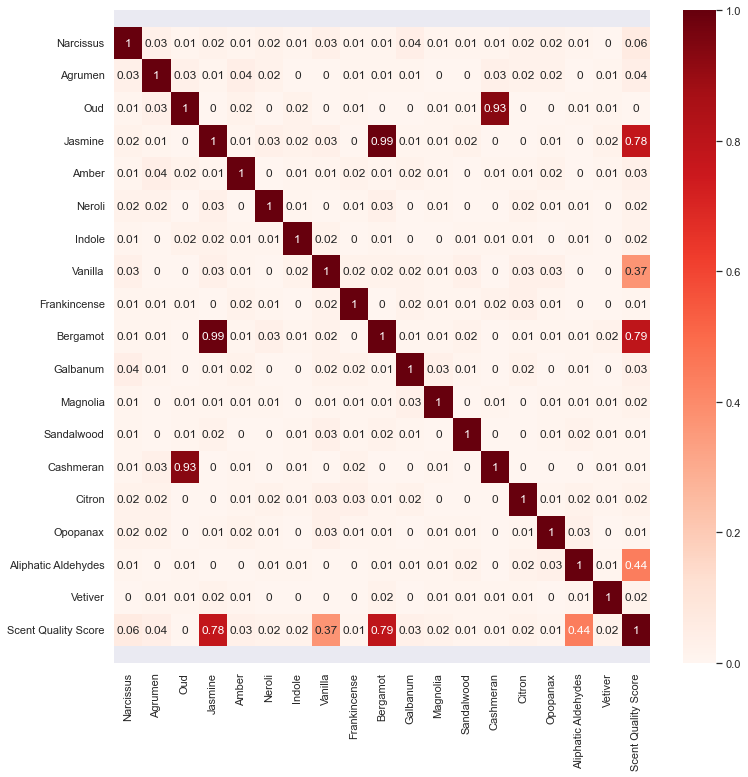

In [5]:
correlation_matrix = np.absolute(df.corr().round(2))
sns.set(rc={'figure.figsize':(12,12)})
ax=sns.heatmap (correlation_matrix,annot=True,cmap='Reds')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom+0.5, top-0.5);

We can focus on the final row or the final column to find the relations of the scent chemicals and the scent quality score. In order to reduce the dummy dimensions, we will choose **Jasmine, Vanilla, Bergamot** and **Aliphatic Aldehydes** (the first 4 scent chemicals whose correlations with 'Scent Quality Score') to build the multi-linear model.

Since we have 5004 datas in total and we are going to use 4 dimensions, the matrix notation is like:

$$\begin{bmatrix}
y_1\\
y_2\\
y_3\\
y_4\\
...\\
y_{5004}\\
\end{bmatrix}=\begin{bmatrix}
x_{0,1}&x_{0,2}&x_{0,3}&...&x_{0,5004}\\
x_{1,1}&x_{1,2}&x_{1,3}&...&x_{1,5004}\\
x_{2,1}&x_{2,2}&x_{2,3}&...&x_{2,5004}\\
x_{3,1}&x_{3,2}&x_{3,3}&...&x_{3,5004}\\
x_{4,1}&x_{4,2}&x_{4,3}&...&x_{4,5004}\\
\end{bmatrix}^T\cdot\begin{bmatrix}
\theta_0\\
\theta_1\\
\theta_2\\
\theta_3\\
\theta_4\\
\end{bmatrix}$$

Then we read data and delete the columns that are not chosen, then will do some basic data processing to transform the format in order to do the next steps:

In [6]:
# convert X1 to array x1a
X1=df.loc[:,'Narcissus':'Vetiver']
X1=X1.drop([ 'Agrumen', 'Oud', 'Amber', 'Neroli', 'Indole', 'Frankincense', 'Galbanum', 'Magnolia', 'Sandalwood', 'Cashmeran', 'Citron', 'Opopanax', 'Vetiver'], axis=1)
x1=X1.values.tolist()
x1a=np.array(x1,dtype=int)
for i in range(0,5004):
    x1a[i][0]=1
    
# convert Y1 to array y1a
Y1=df.loc[:,'Scent Quality Score']
y1=Y1.values.tolist()
y1a=np.asarray(y1,dtype=int)

Since the values in this data set are too large and might meet some errors in the next steps, we now divide x1a and y1a by 1000：

In [7]:
x2a=x1a/1000
y2a=y1a/1000

Next we define a function *gradientDescent*:

In [8]:
def gradientDescent(x, y, theta, alpha, numIterations):
    
    # Check x and y shape
    x_length, x_width = np.shape(x)
    
    if (x_length != y.size):
        raise Exception("Error in gradientDescent : Length of x and data inputs are different")
    else:
        m = x_length
        
    if(x_width < 2):
        raise Exception("Error: x data must contain at least two coloumn with x=[0,n] =1")
        
    # Compute the best fit
    for i in range(0, numIterations):
        best_guess = np.dot(x, theta)
        loss = best_guess - y
        cost = np.sum(loss**2)/(2*m)
        gradient = np.dot(x.T, loss)/m
        theta = theta - alpha * gradient
    return theta

In [9]:
theta=np.ones(5)
theta = gradientDescent(x2a,y2a,theta,alpha=0.0005, numIterations = 200000)
theta

array([  -6.69527935, 1130.25929516, 2574.91754433, 3011.9796113 ,
       3758.64200217])

Based on the model shown above，the **model** which gives pridition of scent quality score can be:

$y = \theta _0 \cdot x_0 +\theta _1 \cdot x_1 + \theta _2 \cdot x_2 + \theta _3 \cdot x_3 + \theta _4 \cdot x_4 =1000 \times ( -6.695 \cdot x_0 /1000 + 1130.259 \cdot x_1/1000 + 2574.918 \cdot x_2/1000 + 3011.980 \cdot x_3/1000) + 3758.642 \cdot x_3/1000)$

Where y is the predicted score, $x_0$ is the bias, $x_1, x_2, x_3$ and $x_4$ represent the scent chemicals with first 4 correlations.

### 2.2 Related Scent Chemicals

#### 2.2.1 Analysis From First Data Set

The requirement is 'Understand if any scent chemicals are strongly related. That is, they have a similar response from customers'. We want to make use of the *scatter_matrix* in Pandas library to show the relationships between these data in the first data set:

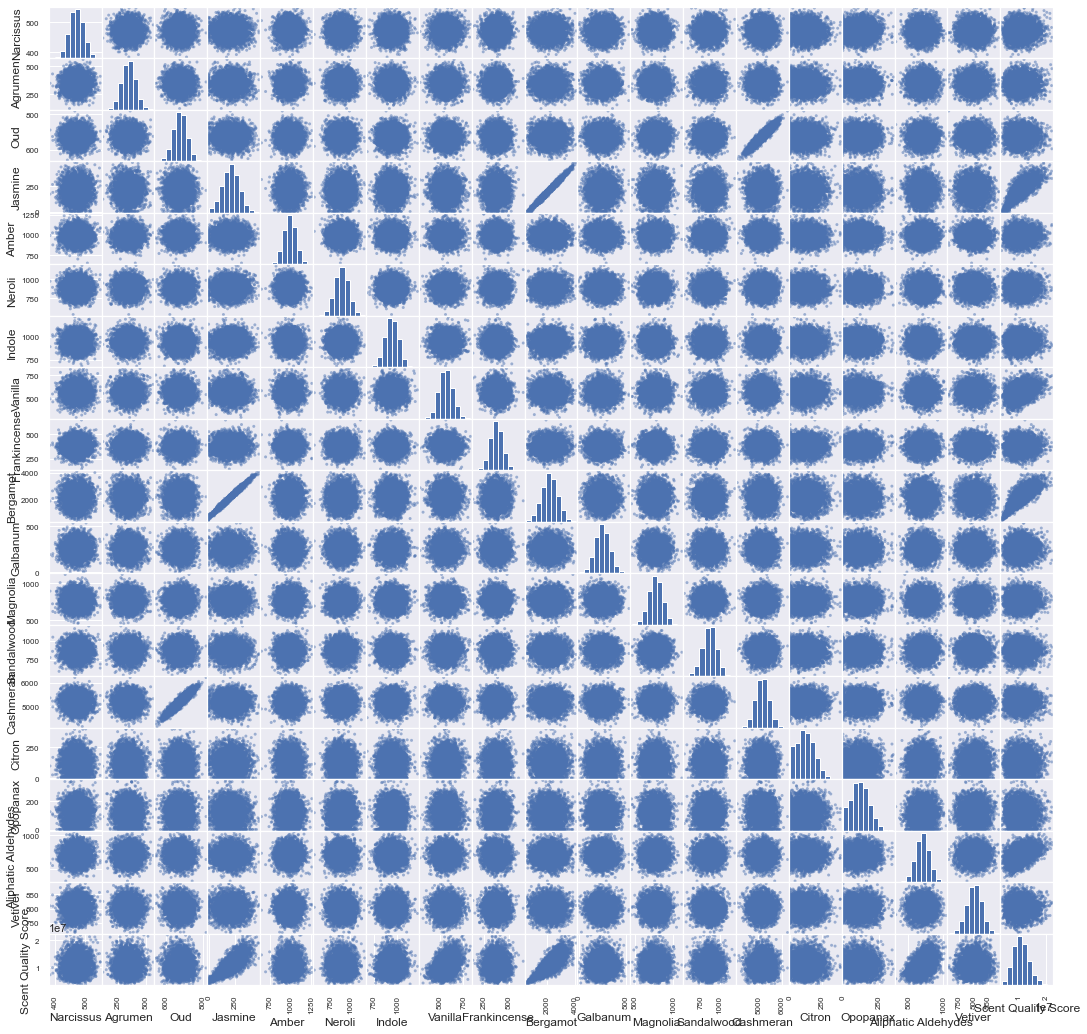

In [10]:
scatter_matrix (df, figsize=(18,18));

From the above matrix, we can get that **Jasmine, Bergamot** have relatively strong relation with score, the higher amount they are added in the scent, the higher score they might have. And the schent chemical **Alphatic Aldehydes** also has such a relation, but less obvious.

#### 2.2.2 Analysis Form Second Data Set

Since the amount of scent chemicals in the first data set is random and the response are spread, the relationship of them are not quit clear. So we only focus on the final row of the metrix. We may also need to refer to the second dataset. Before that, we have to do the data cleansing for the second data set:

In [11]:
# Read data set 2
df2 = pd.read_csv('Perfume preference .csv')
# Drop the first column
df3=df2.drop(['Customer No.'],axis=1)
# Replace the '#VALUE!'
df3=df3.replace('#VALUE!',np.nan)

In [12]:
# Fill the NaN with the mean values
df3=df3.astype('float')
for column in df3:
    df3[column].fillna(df3[column].mean(),inplace = True)
df3

,Narcissus,Agrumen,Oud,Jasmine,Amber,Neroli,Indole,Vanilla,Frankincense,Bergamot,Galbanum,Magnolia,Sandalwood,Cashmeran,Citron,Opopanax,Aliphatic Aldehydes,Vetiver
0,1353.0,1252.0,4066.0,3838.0,2144.0,4404.0,32082.0,3866.0,2505.0,3972.0,4485.0,6441.0,4106.0,1722.0,4287.0,4820.0,4140.0,1463.0
1,1089.0,2152.0,4045.0,3710.0,2235.0,4352.0,30398.0,4769.0,2995.0,4720.0,4532.0,10931.0,3794.0,1638.0,4648.0,4472.0,4184.0,1071.0
2,4177.0,3592.0,3596.0,1745.0,3234.0,2116.0,21678.0,4864.0,3178.0,3381.0,1376.0,18153.0,2502.0,1733.0,1747.0,2728.0,4580.0,4742.0
3,4899.0,3738.0,2454.0,3976.0,4945.0,3853.0,17963.0,3040.0,2943.0,2870.0,4016.0,18819.0,1990.0,5118.0,2391.0,2012.0,3470.0,3057.0
4,4822.0,4030.0,3447.0,4225.0,4078.0,3772.0,23988.0,3389.0,2415.0,2695.0,3887.0,20367.0,2118.0,4530.0,2427.0,3205.0,4319.0,2289.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9492,4857.0,3654.0,2788.0,3830.0,4272.0,4349.0,20816.0,2524.0,2675.0,2550.0,4620.0,18506.0,1999.0,5329.0,2140.0,2568.0,4358.0,2361.0
9493,2040.0,2561.0,3913.0,3375.0,2058.0,4722.0,19399.0,4765.0,3796.0,2949.0,2686.0,13008.0,4201.0,1830.0,1534.0,2272.0,3348.0,2992.0
9494,4846.0,4883.0,4153.0,2108.0,4164.0,1881.0,20551.0,5030.0,2683.0,4001.0,1450.0,24684.0,3979.0,1187.0,2107.0,2508.0,4581.0,4731.0
9495,4310.0,3916.0,3937.0,2488.0,3343.0,2219.0,22914.0,5104.0,2640.0,3864.0,1730.0,19874.0,3654.0,499.0,1920.0,2971.0,4476.0,4654.0


Matrix of the second data set

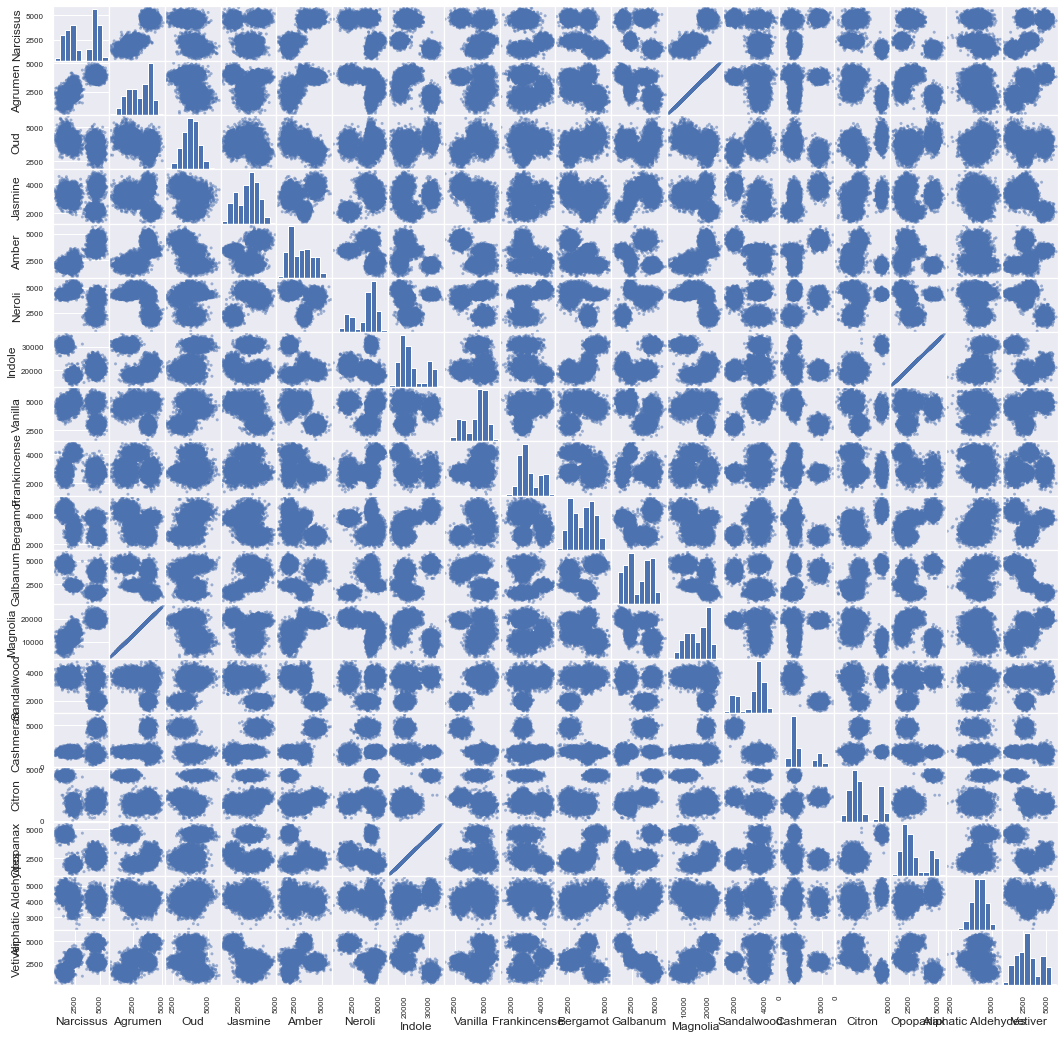

In [13]:
scatter_matrix (df3, figsize=(18,18));

From the scattered matrix of the second data set, we can find more information: **Magnolia** and **Agrumen** have strong positive correlation; **Opopanax** and **Indole** also have strong positive correlation.

Nest block is using the origin values of the second data set with NaN. And the heatmap also gives the same information as the scatter matrix of the second data set.

<AxesSubplot:>

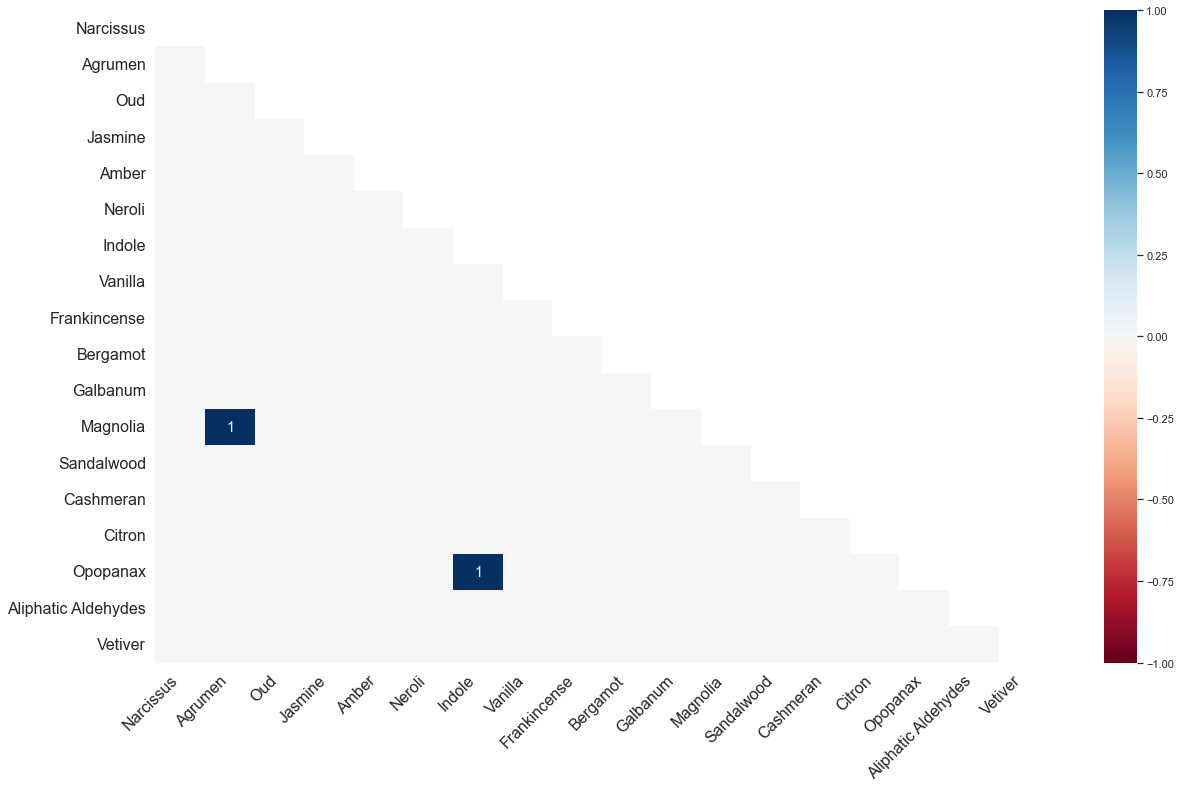

In [14]:
df4=df2.replace('#VALUE!',np.nan)
df4=df4.drop(['Customer No.'],axis=1)
df4=df4.astype('float')
msno.heatmap(df4)

#### 2.2.3 Analysis Based on the Prediction Model Applied Second Data Set

If we apply the model build in part **2.1** and replot the scatter matrix of the second data set, we can get:

In [17]:
# generate the predicted scent quality score
X3=df3.loc[:,'Narcissus':'Vetiver']
X4=X3.drop(['Agrumen', 'Oud', 'Amber', 'Neroli', 'Indole', 'Frankincense', 'Galbanum', 'Magnolia', 'Sandalwood', 'Cashmeran', 'Citron', 'Opopanax', 'Vetiver'], axis=1)
x4=X4.values.tolist()
x4a=np.array(x4,dtype=int)
y4=np.zeros(shape=9497)
for i in range(0, 9496 ):
    x4a[i][0]=1
    for j in range(0,4):
        y4[i] += theta[j]*x4a[i][j]
        
# transform Y4 and form df5 with the prodition scores
Y4 = pd.DataFrame(y4.T, columns=['predicted score'])
Y4
df5=df3.join(Y4)

Then we generate the heatmap of the second data set with the prediction results. Actually, the addition of the predicted score might be not that useful, and might can be an exam of the rationality of the built model. So we will focus on the correlation of the 18 scent chemicals.

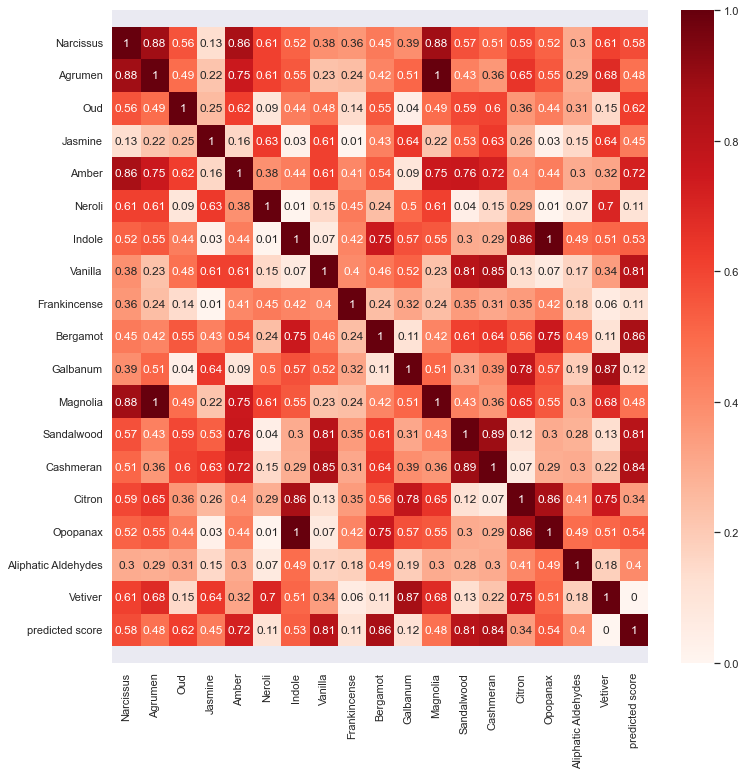

In [18]:
correlation_matrix = np.absolute(df5.corr().round(2))
sns.set(rc={'figure.figsize':(12,12)})
ax=sns.heatmap (correlation_matrix,annot=True,cmap='Reds')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom+0.5, top-0.5);

The heatmat gives the information that: **Agrument** and **Nercissus**; **Amber** and  **Nercissus**; **Magnolia** and **Nercissus**; **Agrument** and **Amber**;  **Agrument** and **Magnolia**; **Amber** and **Magnolia**; **Amber** and **Sandalwood**; **Amber** and **Cashmeran**; **Neroli** and **Vetiver**; **Indole** and **Bergamot**; **Indole** and **Citron**; **Indole** and **Opopanax**; **Vanilla** and **Sandalwood**; **Vanilla** and **Cashmeran**; **Bergmot** and **Opopanax**; **Galbanum** and **Citron**; **Galbanum** and **Vetiver**; **Sandalwood** and **Cashmeran**; **Citron** and **Opopanax**; **Citron** and **Vetiver**.

These pairs have the correlation greater than 0.7. If we rearrange these pairs into unlimitted volumea sets, we can get:
* **Agrument**, **Nercissus**, **Amber**, **Magnolia**, **Sandalwood**, **Cashmeran**, **Vanilla** 
* **Neroli**, **Vetiver**, **Indole**, **Bergamot**, **Citron**, **Opopanax**, **Galbanum**

In each of these two groups, the scent chemeicals shows the similar response from the customer.


#### 2.2.4 Summary

In a sum, we have some conclutions:

* From the matrix of the first data set, we can get that **Jasmine, Bergamot** have relatively strong relation with score, the higher amount they are added in the scent, the higher score they might have. And the schent chemical **Alphatic Aldehydes** also has such a relation, but less obvious.
* From the scattered matrix of the second data set, we can find more information: **Magnolia** and **Agrumen** have strong positive correlation; **Opopanax** and **Indole** also have strong positive correlation.
* From the scattered matrix of the second data set, combine the scent chemicals which have high correlation, we have two groups:
    * **Agrument**, **Nercissus**, **Amber**, **Magnolia**, **Sandalwood**, **Cashmeran**, **Vanilla** 
    * **Neroli**, **Vetiver**, **Indole**, **Bergamot**, **Citron**, **Opopanax**, **Galbanum**


### 2.3 Clustering Customer Data

In this part, the task is to figure out the different groups of the customers and finish some specifications.

#### 2.3.1 Decide the Number of Groups

First step is to decide the number of clusters:

In [19]:
# Scale (standardized) the data into standard size
standardized = preprocessing.scale(df3)
standardized_df3 = pd.DataFrame(df3, columns = df3.columns)

Two method that can be used to decide the cluster number:
    
1. Silhouette Method
2. Elbow Method

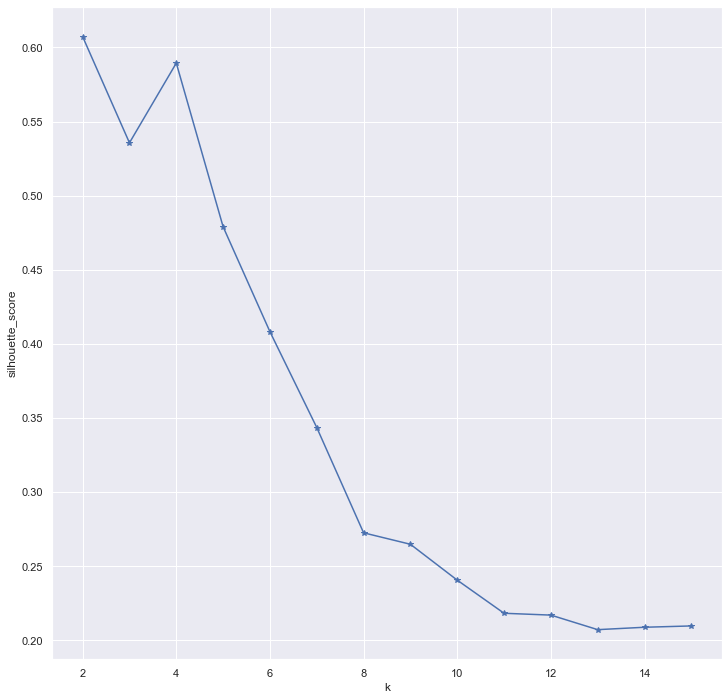

In [20]:
# Silhouette Method
def k_silhouette(X, clusters):
    K = range(2, clusters+1)
    S = []
    for k in K:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        labels = kmeans.labels_
        S.append(metrics.silhouette_score(X, labels, metric ='euclidean'))
        
    plt.plot(K, S, 'b*-')
    plt.xlabel('k')
    plt.ylabel('silhouette_score')
        
    plt.show();
        
k_silhouette(standardized_df3, 15)

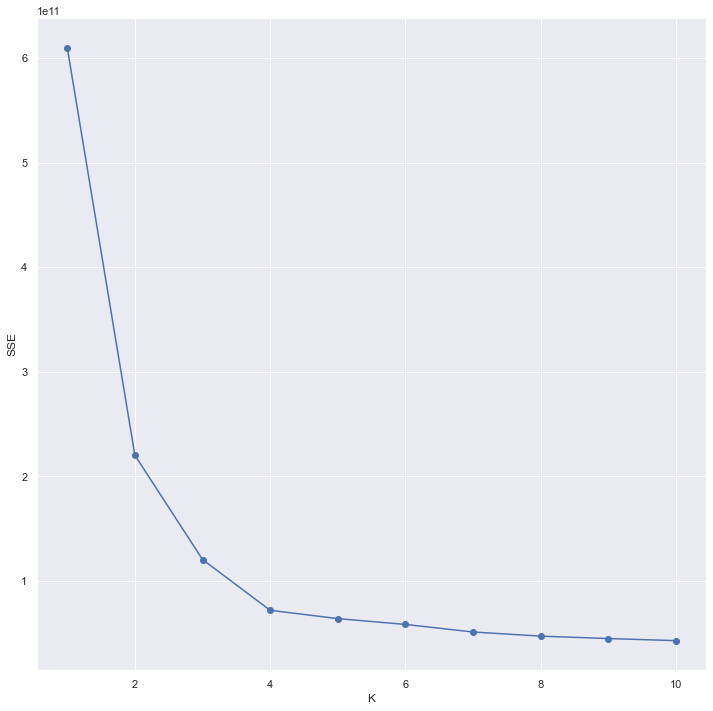

In [21]:
# Elbow Method
# sse: standard square error
import matplotlib.pyplot as plt
sse = []
for k in range(1,11):
        kmeans = KMeans(n_clusters=k,)
        kmeans.fit(standardized_df3)
        sse.append(kmeans.inertia_)
x = range(1,11)
plt.xlabel('K')
plt.ylabel('SSE')
plt.plot(x,sse,'o-')
plt.show()

Based on these two methods, we choose the number of cluster here is 4. 

Then we cluster the data and build the model:

In [22]:
# create the machine
kmeans = KMeans(n_clusters=4)
# identify the cluster number
kmeans.fit(standardized_df3)

KMeans(n_clusters=4)

Having indentified in centres of each cluster, we now assign each member of the data-set to one of the clusters. Members are assigned to the cluster which has it centre closest to it.

In [23]:
y_km = kmeans.fit_predict(standardized_df3)

Now we can review the results and check wheather this is reasonable. First plotting **Narcissus** Vs **Jasmine**

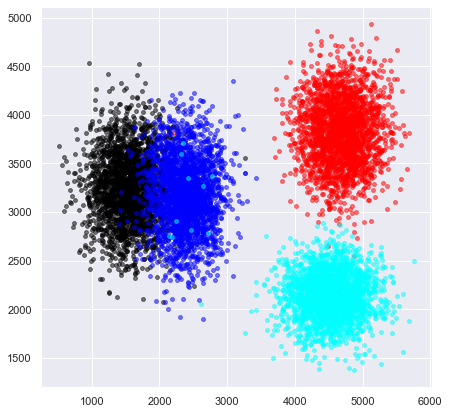

In [24]:
# Narcissus vs Jasmine
plt.figure(figsize=(7,7))
plt.scatter(df3[y_km == 0]['Narcissus'], df3[y_km == 0]['Jasmine'],
           s = 15, c='red',alpha=.5)
plt.scatter(df3[y_km == 1]['Narcissus'], df3[y_km == 1]['Jasmine'],
           s = 15, c='black',alpha=.5)
plt.scatter(df3[y_km == 2]['Narcissus'], df3[y_km == 2]['Jasmine'],
           s = 15, c='blue',alpha=.5)
plt.scatter(df3[y_km == 3]['Narcissus'], df3[y_km == 3]['Jasmine'],
           s = 15, c='cyan',alpha=.5)

This result shows in these two dimentions, the 4 clusters seperate well. Then we plot **Neroli** Vs **Oud**

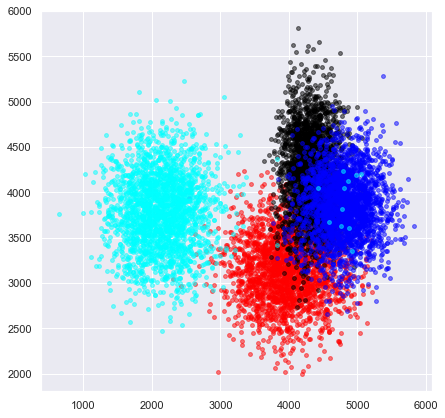

In [25]:
# Neroli vs Oud
plt.figure(figsize=(7,7))
plt.scatter(df3[y_km == 0]['Neroli'], df3[y_km == 0]['Oud'],
           s = 15, c='red',alpha=.5)
plt.scatter(df3[y_km == 1]['Neroli'], df3[y_km == 1]['Oud'],
           s = 15, c='black',alpha=.5)
plt.scatter(df3[y_km == 2]['Neroli'], df3[y_km == 2]['Oud'],
           s = 15, c='blue',alpha=.5)
plt.scatter(df3[y_km == 3]['Neroli'], df3[y_km == 3]['Oud'],
           s = 15, c='cyan',alpha=.5)

Next, plot **Galbanum** Vs **Oud**

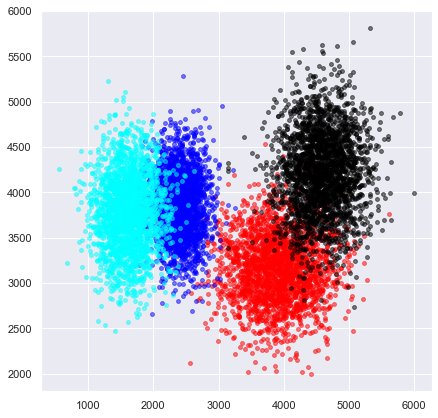

In [26]:
# Galbanum vs Oud
plt.figure(figsize=(7,7))
plt.scatter(df3[y_km == 0]['Galbanum'], df3[y_km == 0]['Oud'],
           s = 15, c='red',alpha=.5)
plt.scatter(df3[y_km == 1]['Galbanum'], df3[y_km == 1]['Oud'],
           s = 15, c='black',alpha=.5)
plt.scatter(df3[y_km == 2]['Galbanum'], df3[y_km == 2]['Oud'],
           s = 15, c='blue',alpha=.5)
plt.scatter(df3[y_km == 3]['Galbanum'], df3[y_km == 3]['Oud'],
           s = 15, c='cyan',alpha=.5)

#### 2.3.2 Best Mixture for Each Group

To decide the best mixture of each group, we use the function to calculate the mean values of each scent chemical.

In [27]:
# Four groups:
df00=df3[y_km==0]
df01=df3[y_km==1]
df02=df3[y_km==2]
df03=df3[y_km==3]

#### 2.3.2.1 First Cluster

Mean values of the first group:

In [28]:
meanMix00 = pd.DataFrame(np.array([['Narcissus',df00['Narcissus'].mean()],['Agrumen',df00['Agrumen'].mean()], ['Oud',df00['Oud'].mean()],['Jasmine',df00['Jasmine'].mean()],['Amber',df00['Amber'].mean()], ['Neroli',df00['Neroli'].mean()], ['Indole',df00['Indole'].mean()], ['Vanilla',df00['Vanilla'].mean()], ['Frankincense',df00['Frankincense'].mean()], ['Bergamot',df00['Bergamot'].mean()], ['Galbanum',df00['Galbanum'].mean()], ['Magnolia',df00['Magnolia'].mean()], ['Sandalwood',df00['Sandalwood'].mean()], ['Cashmeran',df00['Cashmeran'].mean()], ['Citron',df00['Citron'].mean()], ['Opopanax',df00['Opopanax'].mean()], ['Aliphatic Aldehydes',df00['Aliphatic Aldehydes'].mean()], ['Vetiver',df00['Vetiver'].mean()]]), columns=['mixture','mean values'], index =['Narcissus','Agrumen','Oud','Jasmine','Amber','Neroli','Indole','Vanilla','Frankincense','Bergamot','Galbanum','Magnolia','Sandawood','Cashmeran','Citron','Opopanax','Aliphatic Aldehydes','Vetiver'] )
meanMix00=meanMix00.explode('mean values')
meanMix00['mean values']=meanMix00['mean values'].astype('float')
meanMix00

,mixture,mean values
Narcissus,Narcissus,4675.486281
Agrumen,Agrumen,3819.082632
Oud,Oud,3158.429078
Jasmine,Jasmine,3825.114850
Amber,Amber,4367.748417
Neroli,Neroli,3977.561418
Indole,Indole,19897.121591
Vanilla,Vanilla,3003.517940
Frankincense,Frankincense,2705.038198
Bergamot,Bergamot,2583.582970


Visualization of the mean values of the first group:

1. Histogram
2. Pie Chart

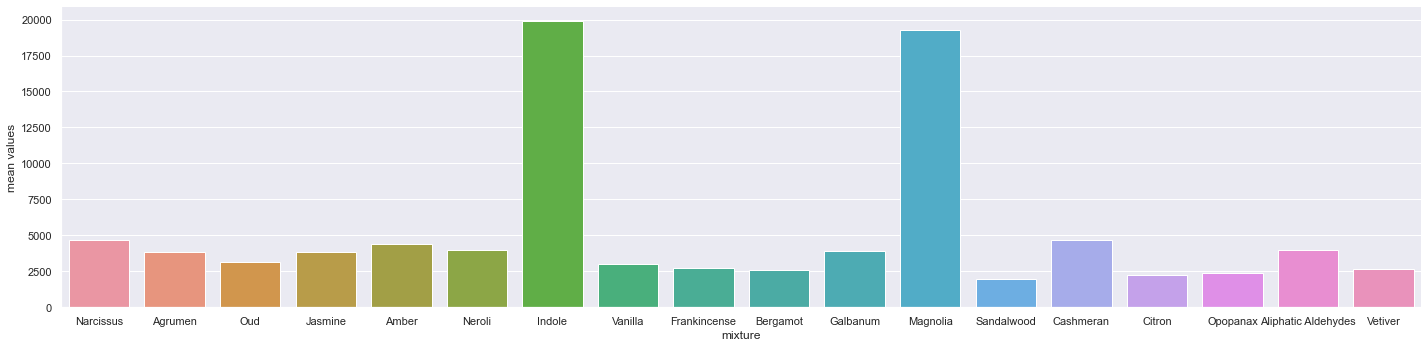

In [29]:
# Histogram
sns.set(rc = {'figure.figsize':(15,10)})
sns.catplot(x='mixture',y='mean values',data=meanMix00, kind='bar',ci=None, height=5,aspect=4)

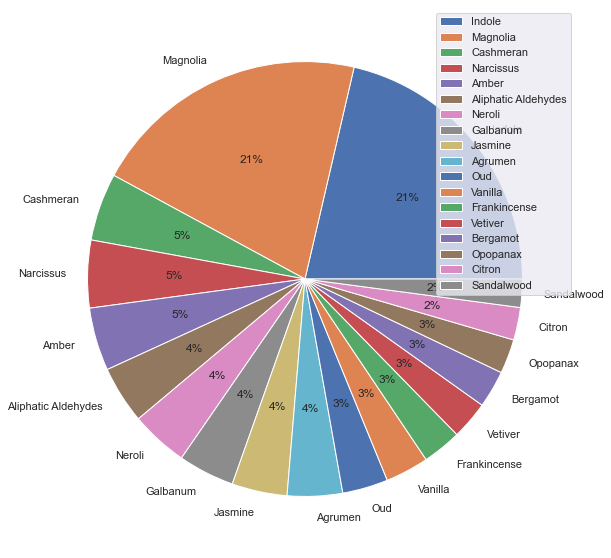

In [30]:
# Pie Chart
mix00 = meanMix00.groupby('mixture').sum()['mean values'].sort_values(ascending=False)
#print(mix00.index)
#print(mix00.values)
plt.pie(mix00.values, labels=mix00.index, autopct='%.f%%')
plt.legend(mix00.index, loc='upper right')
plt.show()

#### 2.3.2.2 Second Cluster

Mean values of the second group:

In [31]:
meanMix01 = pd.DataFrame(np.array([['Narcissus',df01['Narcissus'].mean()],['Agrumen',df01['Agrumen'].mean()], ['Oud',df01['Oud'].mean()],['Jasmine',df01['Jasmine'].mean()],['Amber',df01['Amber'].mean()], ['Neroli',df01['Neroli'].mean()], ['Indole',df01['Indole'].mean()], ['Vanilla',df01['Vanilla'].mean()], ['Frankincense',df01['Frankincense'].mean()], ['Bergamot',df01['Bergamot'].mean()], ['Galbanum',df01['Galbanum'].mean()], ['Magnolia',df01['Magnolia'].mean()], ['Sandalwood',df01['Sandalwood'].mean()], ['Cashmeran',df01['Cashmeran'].mean()], ['Citron',df01['Citron'].mean()], ['Opopanax',df01['Opopanax'].mean()], ['Aliphatic Aldehydes',df01['Aliphatic Aldehydes'].mean()], ['Vetiver',df01['Vetiver'].mean()]]), columns=['mixture','mean values'], index =['Narcissus','Agrumen','Oud','Jasmine','Amber','Neroli','Indole','Vanilla','Frankincense','Bergamot','Galbanum','Magnolia','Sandawood','Cashmeran','Citron','Opopanax','Aliphatic Aldehydes','Vetiver'] )
meanMix01=meanMix01.explode('mean values')
meanMix01['mean values']=meanMix01['mean values'].astype('float')
meanMix01

,mixture,mean values
Narcissus,Narcissus,1549.215593
Agrumen,Agrumen,1939.696455
Oud,Oud,4230.649808
Jasmine,Jasmine,3254.966191
Amber,Amber,2010.817202
Neroli,Neroli,4317.220619
Indole,Indole,30914.360579
Vanilla,Vanilla,4418.543541
Frankincense,Frankincense,2824.207489
Bergamot,Bergamot,4313.353352


Visualization of the mean values of the second group:

1. Histogram
2. Pie Chart

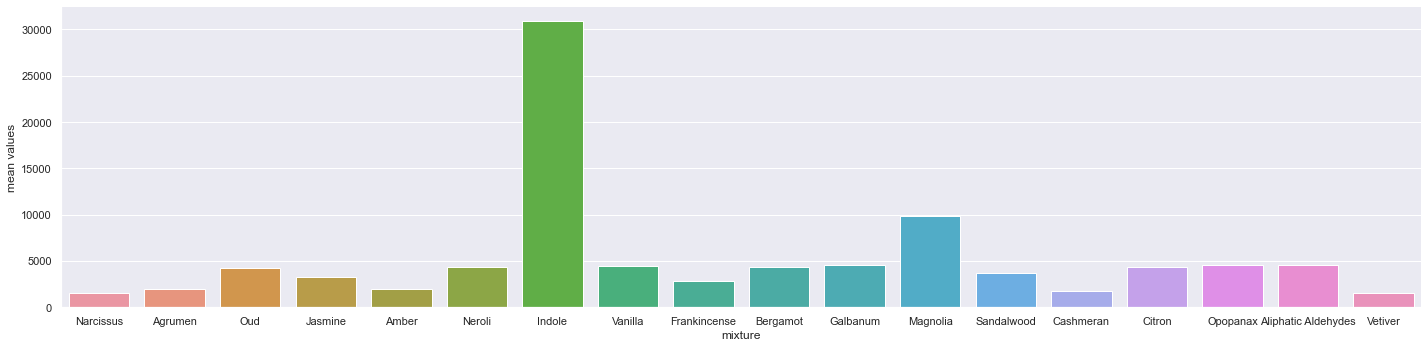

In [32]:
# Histogram
sns.set(rc = {'figure.figsize':(15,10)})
sns.catplot(x='mixture',y='mean values',data=meanMix01, kind='bar',ci=None, height=5,aspect=4)

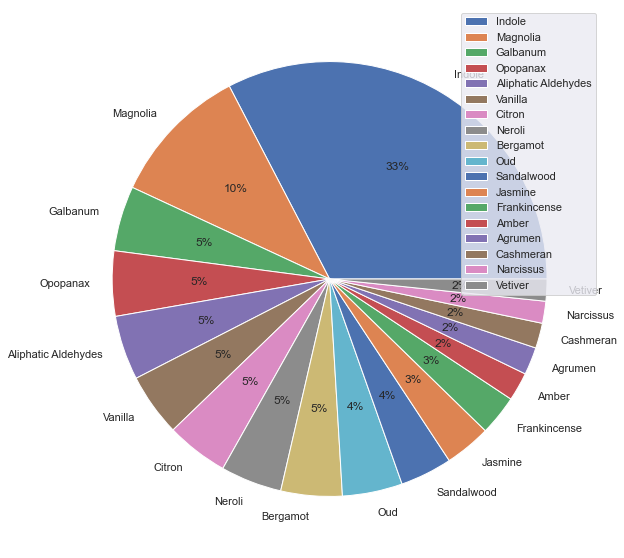

In [33]:
# Pie Chart
mix01 = meanMix01.groupby('mixture').sum()['mean values'].sort_values(ascending=False)
# print(mix01.index)
# print(mix01.values)
plt.pie(mix01.values, labels=mix01.index, autopct='%.f%%')
plt.legend(mix01.index, loc='upper right')
plt.show()

#### 2.3.2.3 Third Cluster

Mean values of the third group:

In [34]:
meanMix02 = pd.DataFrame(np.array([['Narcissus',df02['Narcissus'].mean()],['Agrumen',df02['Agrumen'].mean()], ['Oud',df02['Oud'].mean()],['Jasmine',df02['Jasmine'].mean()],['Amber',df02['Amber'].mean()], ['Neroli',df02['Neroli'].mean()], ['Indole',df02['Indole'].mean()], ['Vanilla',df02['Vanilla'].mean()], ['Frankincense',df02['Frankincense'].mean()], ['Bergamot',df02['Bergamot'].mean()], ['Galbanum',df02['Galbanum'].mean()], ['Magnolia',df02['Magnolia'].mean()], ['Sandalwood',df02['Sandalwood'].mean()], ['Cashmeran',df02['Cashmeran'].mean()], ['Citron',df02['Citron'].mean()], ['Opopanax',df02['Opopanax'].mean()], ['Aliphatic Aldehydes',df02['Aliphatic Aldehydes'].mean()], ['Vetiver',df02['Vetiver'].mean()]]), columns=['mixture','mean values'], index =['Narcissus','Agrumen','Oud','Jasmine','Amber','Neroli','Indole','Vanilla','Frankincense','Bergamot','Galbanum','Magnolia','Sandawood','Cashmeran','Citron','Opopanax','Aliphatic Aldehydes','Vetiver'] )
meanMix02=meanMix02.explode('mean values')
meanMix02['mean values']=meanMix02['mean values'].astype('float')
meanMix02

,mixture,mean values
Narcissus,Narcissus,2383.203108
Agrumen,Agrumen,2730.863579
Oud,Oud,3862.732313
Jasmine,Jasmine,3176.086737
Amber,Amber,2300.577297
Neroli,Neroli,4801.249171
Indole,Indole,17950.265284
Vanilla,Vanilla,4914.803462
Frankincense,Frankincense,4104.824207
Bergamot,Bergamot,2984.341967


Visualization of the mean values of the third group:

1. Histogram
2. Pie Chart

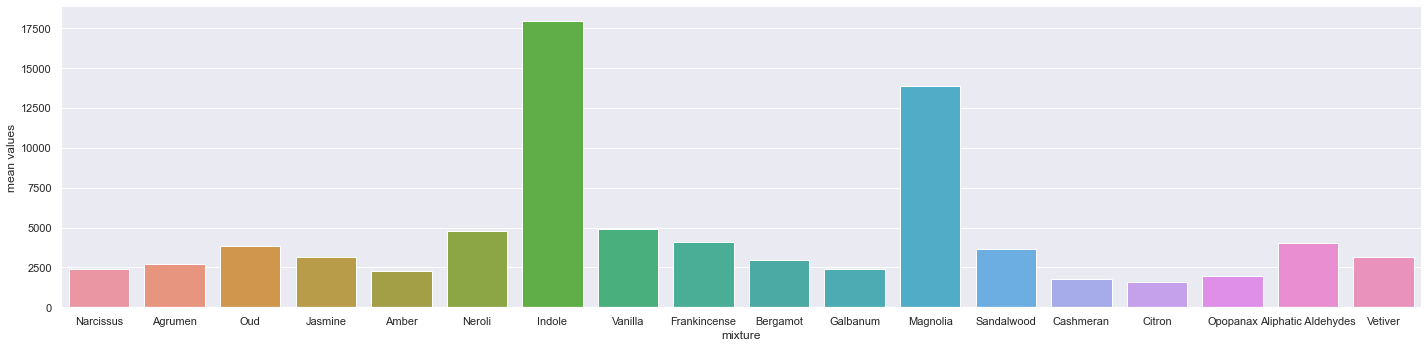

In [35]:
# Histogram
sns.set(rc = {'figure.figsize':(15,10)})
sns.catplot(x='mixture',y='mean values',data=meanMix02, kind='bar',ci=None, height=5,aspect=4)

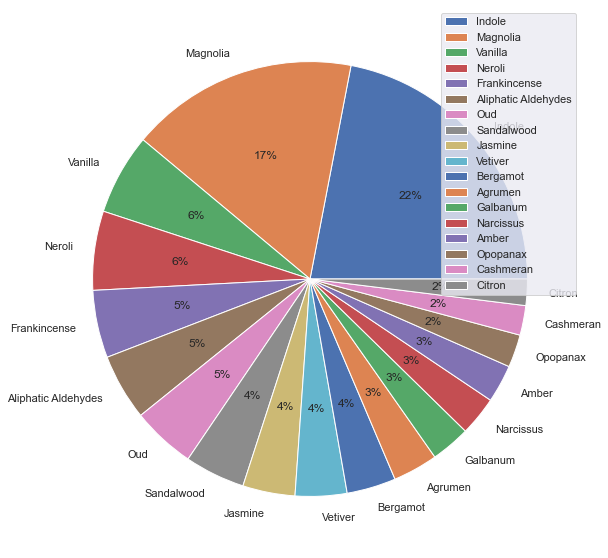

In [36]:
# Pie Chart
mix02 = meanMix02.groupby('mixture').sum()['mean values'].sort_values(ascending=False)
#print(mix02.index)
#print(mix02.values)
plt.pie(mix02.values, labels=mix02.index, autopct='%.f%%')
plt.legend(mix02.index, loc='upper right')
plt.show()

#### 2.3.2.4 fourth Cluster

Mean values of the fourth group:

In [38]:
meanMix03 = pd.DataFrame(np.array([['Narcissus',df03['Narcissus'].mean()],['Agrumen',df03['Agrumen'].mean()], ['Oud',df03['Oud'].mean()],['Jasmine',df03['Jasmine'].mean()],['Amber',df03['Amber'].mean()], ['Neroli',df03['Neroli'].mean()], ['Indole',df03['Indole'].mean()], ['Vanilla',df03['Vanilla'].mean()], ['Frankincense',df03['Frankincense'].mean()], ['Bergamot',df03['Bergamot'].mean()], ['Galbanum',df03['Galbanum'].mean()], ['Magnolia',df03['Magnolia'].mean()], ['Sandalwood',df03['Sandalwood'].mean()], ['Cashmeran',df03['Cashmeran'].mean()], ['Citron',df03['Citron'].mean()], ['Opopanax',df03['Opopanax'].mean()], ['Aliphatic Aldehydes',df03['Aliphatic Aldehydes'].mean()], ['Vetiver',df03['Vetiver'].mean()]]), columns=['mixture','mean values'], index =['Narcissus','Agrumen','Oud','Jasmine','Amber','Neroli','Indole','Vanilla','Frankincense','Bergamot','Galbanum','Magnolia','Sandawood','Cashmeran','Citron','Opopanax','Aliphatic Aldehydes','Vetiver'] )
meanMix03=meanMix03.explode('mean values')
meanMix03['mean values']=meanMix03['mean values'].astype('float')
meanMix03

,mixture,mean values
Narcissus,Narcissus,4515.560250
Agrumen,Agrumen,4040.435946
Oud,Oud,3790.705033
Jasmine,Jasmine,2148.821030
Amber,Amber,3371.657974
Neroli,Neroli,2149.790799
Indole,Indole,21998.550079
Vanilla,Vanilla,4918.050406
Frankincense,Frankincense,2820.170706
Bergamot,Bergamot,3810.166953


Visualization of the mean values of the fourth group:

1. Histogram
2. Pie Chart

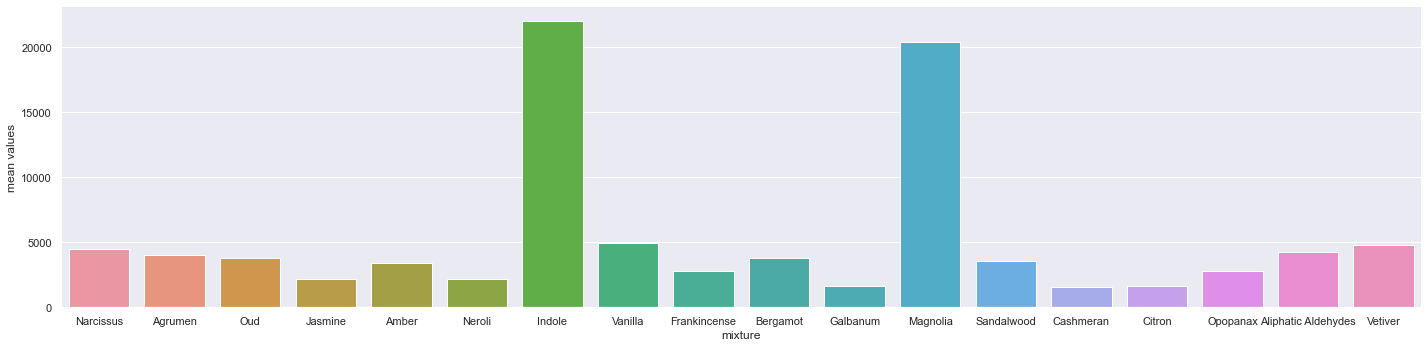

In [39]:
# Histogram
sns.set(rc = {'figure.figsize':(15,10)})
sns.catplot(x='mixture',y='mean values',data=meanMix03, kind='bar',ci=None, height=5,aspect=4)

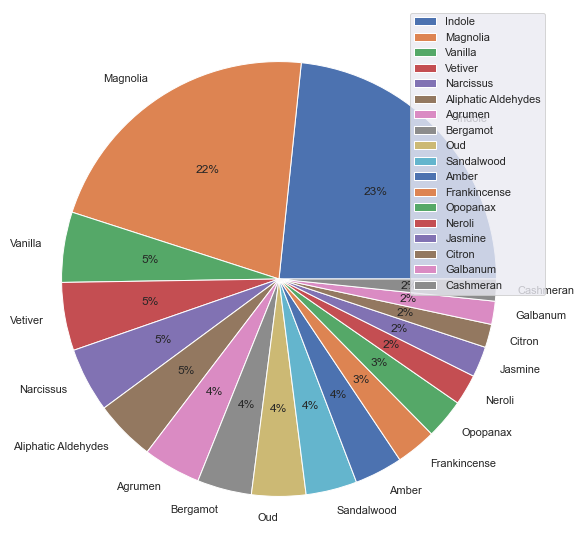

In [40]:
# Pie Chart
mix03 = meanMix03.groupby('mixture').sum()['mean values'].sort_values(ascending=False)
# print(mix03.index)
# print(mix03.values)
plt.pie(mix03.values, labels=mix03.index, autopct='%.f%%')
plt.legend(mix03.index, loc='upper right')
plt.show()

#### 2.3.3 Variance for Each Groups

This part is to calculate the spread for each group for each dimension, which is for each quantity of scent chemical.

#### 2.3.3.1 Variance of First Group

The variance is shown in two ways:

1. Quantitive prezentation
2. Graphical chart

The variances of the first group is shown in *varMix00*

In [41]:
# Quantitive presentation
varMix00 = pd.DataFrame(np.array([['Narcissus',df00['Narcissus'].var()],['Agrumen',df00['Agrumen'].var()], ['Oud',df00['Oud'].var()],['Jasmine',df00['Jasmine'].var()],['Amber',df00['Amber'].var()], ['Neroli',df00['Neroli'].var()], ['Indole',df00['Indole'].var()], ['Vanilla',df00['Vanilla'].var()], ['Frankincense',df00['Frankincense'].var()], ['Bergamot',df00['Bergamot'].var()], ['Galbanum',df00['Galbanum'].var()], ['Magnolia',df00['Magnolia'].var()], ['Sandalwood',df00['Sandalwood'].var()], ['Cashmeran',df00['Cashmeran'].var()], ['Citron',df00['Citron'].var()], ['Opopanax',df00['Opopanax'].var()], ['Aliphatic Aldehydes',df00['Aliphatic Aldehydes'].var()], ['Vetiver',df00['Vetiver'].var()]]), columns=['mixture','variance'] )
varMix00=varMix00.explode('variance')
varMix00['variance']=varMix00['variance'].astype('float')
varMix00

,mixture,variance
0,Narcissus,1.066747e+05
1,Agrumen,6.044279e+04
2,Oud,1.339696e+05
3,Jasmine,1.140874e+05
4,Amber,1.385232e+05
5,Neroli,1.833569e+05
6,Indole,2.481692e+06
7,Vanilla,9.908771e+04
8,Frankincense,4.697482e+04
9,Bergamot,5.826839e+04


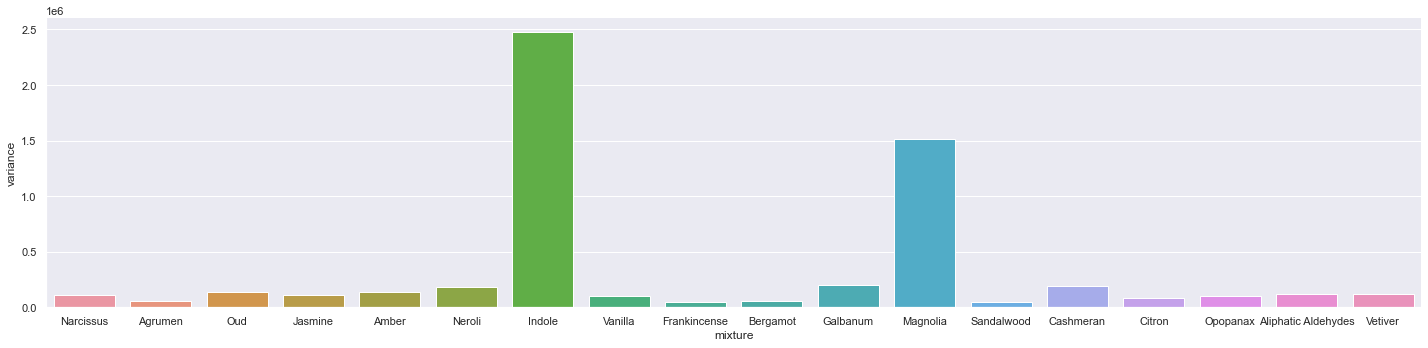

In [42]:
# Graphical chart
sns.set(rc = {'figure.figsize':(15,10)})
sns.catplot(x='mixture',y='variance',data=varMix00, kind='bar',ci=None, height=5,aspect=4)

#### 2.3.3.2 Variance of Second Group
The variance is shown in two ways:

1. Quantitive prezentation
2. Graphical chart

The variances of the second group is shown in *varMix02*

In [43]:
# Quantitive presentation
varMix01 = pd.DataFrame(np.array([['Narcissus',df01['Narcissus'].var()],['Agrumen',df01['Agrumen'].var()], ['Oud',df01['Oud'].var()],['Jasmine',df01['Jasmine'].var()],['Amber',df01['Amber'].var()], ['Neroli',df01['Neroli'].var()], ['Indole',df01['Indole'].var()], ['Vanilla',df01['Vanilla'].var()], ['Frankincense',df01['Frankincense'].var()], ['Bergamot',df01['Bergamot'].var()], ['Galbanum',df01['Galbanum'].var()], ['Magnolia',df01['Magnolia'].var()], ['Sandalwood',df01['Sandalwood'].var()], ['Cashmeran',df01['Cashmeran'].var()], ['Citron',df01['Citron'].var()], ['Opopanax',df01['Opopanax'].var()], ['Aliphatic Aldehydes',df01['Aliphatic Aldehydes'].var()], ['Vetiver',df01['Vetiver'].var()]]), columns=['mixture','variance'] )
varMix01=varMix01.explode('variance')
varMix01['variance']=varMix01['variance'].astype('float')
varMix01

,mixture,variance
0,Narcissus,9.727315e+04
1,Agrumen,1.945573e+05
2,Oud,1.963622e+05
3,Jasmine,1.290110e+05
4,Amber,6.921415e+04
5,Neroli,4.726164e+04
6,Indole,1.778870e+06
7,Vanilla,1.525763e+05
8,Frankincense,1.786784e+05
9,Bergamot,7.896661e+04


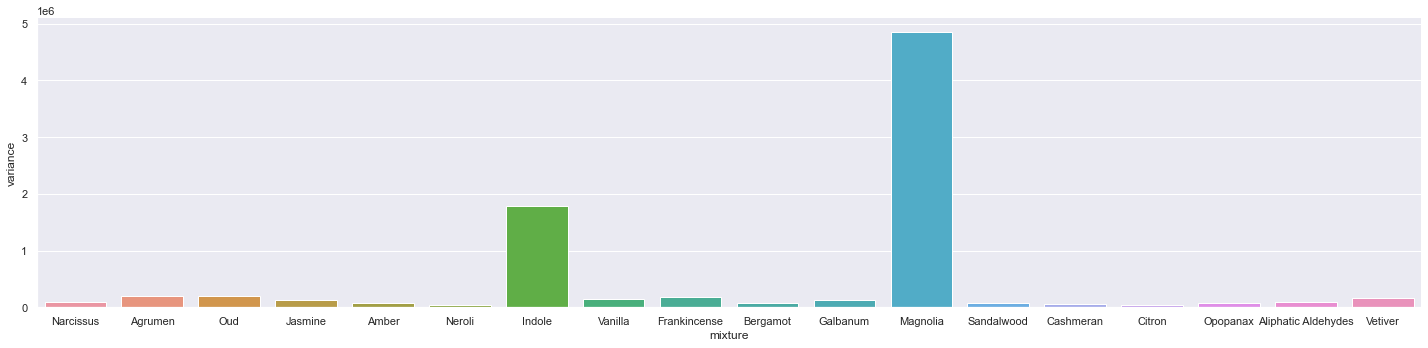

In [44]:
# Graphical chart
sns.set(rc = {'figure.figsize':(15,10)})
sns.catplot(x='mixture',y='variance',data=varMix01, kind='bar',ci=None, height=5,aspect=4)

#### 2.3.3.3 Variance of Third Group
The variance is shown in two ways:

1. Quantitive prezentation
2. Graphical chart

The variances of the third group is shown in *varMix02*

In [45]:
# Quantitive presentation
varMix02 = pd.DataFrame(np.array([['Narcissus',df02['Narcissus'].var()],['Agrumen',df02['Agrumen'].var()], ['Oud',df02['Oud'].var()],['Jasmine',df02['Jasmine'].var()],['Amber',df02['Amber'].var()], ['Neroli',df02['Neroli'].var()], ['Indole',df02['Indole'].var()], ['Vanilla',df02['Vanilla'].var()], ['Frankincense',df02['Frankincense'].var()], ['Bergamot',df02['Bergamot'].var()], ['Galbanum',df02['Galbanum'].var()], ['Magnolia',df02['Magnolia'].var()], ['Sandalwood',df02['Sandalwood'].var()], ['Cashmeran',df02['Cashmeran'].var()], ['Citron',df02['Citron'].var()], ['Opopanax',df02['Opopanax'].var()], ['Aliphatic Aldehydes',df02['Aliphatic Aldehydes'].var()], ['Vetiver',df02['Vetiver'].var()]]), columns=['mixture','variance'] )
varMix02=varMix02.explode('variance')
varMix02['variance']=varMix02['variance'].astype('float')
varMix02

,mixture,variance
0,Narcissus,8.272034e+04
1,Agrumen,1.796685e+05
2,Oud,1.249480e+05
3,Jasmine,1.376590e+05
4,Amber,1.753197e+05
5,Neroli,1.023395e+05
6,Indole,1.817093e+06
7,Vanilla,1.466248e+05
8,Frankincense,4.508991e+04
9,Bergamot,1.590734e+05


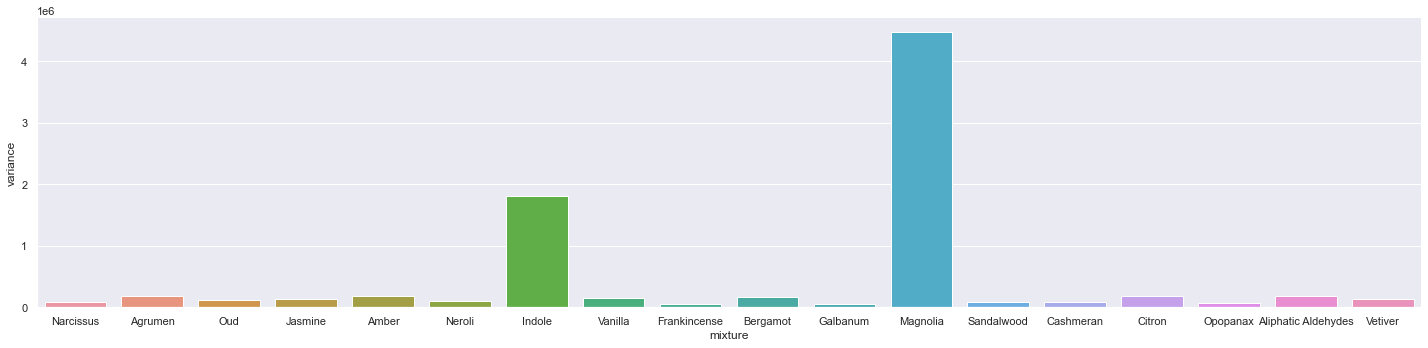

In [46]:
# Graphical chart
sns.set(rc = {'figure.figsize':(15,10)})
sns.catplot(x='mixture',y='variance',data=varMix02, kind='bar',ci=None, height=5,aspect=4)

#### 2.3.3.4 Variance of Fourth Group
The variance is shown in two ways:

1. Quantitive prezentation
2. Graphical chart

The variances of the fourth group is shown in *varMix03*

In [47]:
# Quantitive presentation
varMix03 = pd.DataFrame(np.array([['Narcissus',df03['Narcissus'].var()],['Agrumen',df03['Agrumen'].var()], ['Oud',df03['Oud'].var()],['Jasmine',df03['Jasmine'].var()],['Amber',df03['Amber'].var()], ['Neroli',df03['Neroli'].var()], ['Indole',df03['Indole'].var()], ['Vanilla',df03['Vanilla'].var()], ['Frankincense',df03['Frankincense'].var()], ['Bergamot',df03['Bergamot'].var()], ['Galbanum',df03['Galbanum'].var()], ['Magnolia',df03['Magnolia'].var()], ['Sandalwood',df03['Sandalwood'].var()], ['Cashmeran',df03['Cashmeran'].var()], ['Citron',df03['Citron'].var()], ['Opopanax',df03['Opopanax'].var()], ['Aliphatic Aldehydes',df03['Aliphatic Aldehydes'].var()], ['Vetiver',df03['Vetiver'].var()]]), columns=['mixture','variance'] )
varMix03=varMix03.explode('variance')
varMix03['variance']=varMix03['variance'].astype('float')
varMix03

,mixture,variance
0,Narcissus,1.420197e+05
1,Agrumen,9.084839e+04
2,Oud,1.675395e+05
3,Jasmine,5.923880e+04
4,Amber,6.152771e+04
5,Neroli,1.794520e+05
6,Indole,3.649471e+06
7,Vanilla,1.235756e+05
8,Frankincense,1.576649e+05
9,Bergamot,4.495871e+04


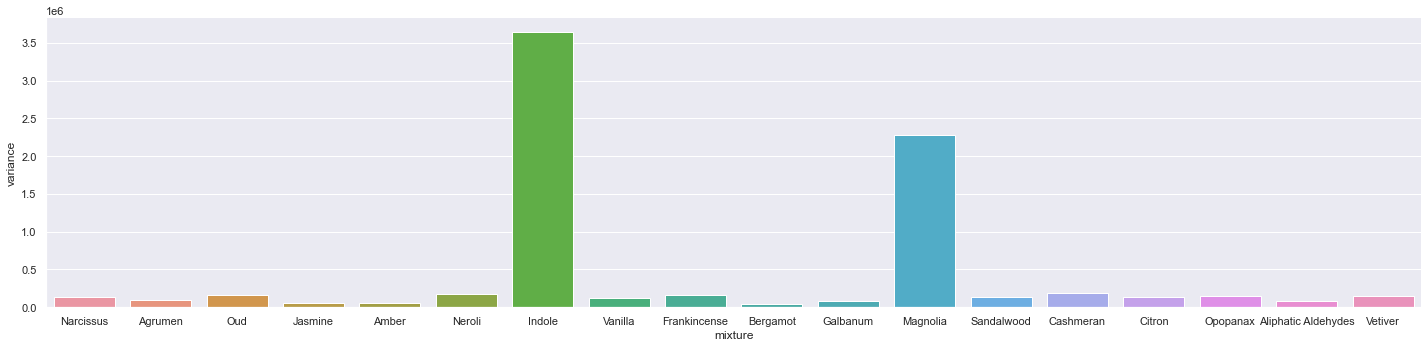

In [48]:
# Graphical chart
sns.set(rc = {'figure.figsize':(15,10)})
sns.catplot(x='mixture',y='variance',data=varMix03, kind='bar',ci=None, height=5,aspect=4)

#### 2.3.4 3D View of 4 Groups

We can also take a '3D' view of the data, the separation of the data points shows the rationality of the model.

In [49]:
%matplotlib
fig = plt.figure(figsize=(10,10))
ax=fig.add_subplot(111,projection ='3d')
ax.view_init(20,20)
ax.set_xlabel('Frankincense')
ax.set_ylabel('Narcissus')
ax.set_zlabel('Jasmine')
ax.scatter(df3[y_km==0]['Frankincense'], df3[y_km==0]['Narcissus'],
          df3[y_km==0]['Jasmine'], s=15,c='red',alpha=.3)
ax.scatter(df3[y_km==1]['Frankincense'], df3[y_km==1]['Narcissus'],
          df3[y_km==1]['Jasmine'], s=15,c='black',alpha=.3)
ax.scatter(df3[y_km==2]['Frankincense'], df3[y_km==2]['Narcissus'],
          df3[y_km==2]['Jasmine'], s=15,c='blue',alpha=.3)
ax.scatter(df3[y_km==3]['Frankincense'], df3[y_km==3]['Narcissus'],
          df3[y_km==3]['Jasmine'], s=15,c='cyan',alpha=.3)

Using matplotlib backend: Qt5Agg
